In [50]:
import pandas as pd
import random
import nltk
import numpy as np
import string
import re
from nltk.util import ngrams
from nltk import TreebankWordTokenizer, ngrams, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download("punkt")
nltk.download('wordnet')
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
path ="/content/drive/MyDrive/Dataset/Resume dataset.csv"
df=pd.read_csv(path)
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [53]:
num_rows = len(df)
print("Number of rows in the dataset:", num_rows)

Number of rows in the dataset: 2484


In [54]:
df.drop(columns=["ID", "Resume_html"], inplace=True)
df.groupby('Category').describe()

Resume_str         \
                            count unique   
Category                                   
ACCOUNTANT                    118    118   
ADVOCATE                      118    118   
AGRICULTURE                    63     63   
APPAREL                        97     97   
ARTS                          103    103   
AUTOMOBILE                     36     36   
AVIATION                      117    116   
BANKING                       115    115   
BPO                            22     22   
BUSINESS-DEVELOPMENT          120    120   
CHEF                          118    118   
CONSTRUCTION                  112    112   
CONSULTANT                    115    115   
DESIGNER                      107    107   
DIGITAL-MEDIA                  96     96   
ENGINEERING                   118    118   
FINANCE                       118    117   
FITNESS                       117    117   
HEALTHCARE                    115    115   
HR                            110    110   
INFORMATION-TECHNOLOGY        120    120   
PUBLIC-RELATIONS              111    111   
SALES                         116    116   
TEACHER                       102    102   

                                                                                
                                                                      top freq  
Category                                                                        
ACCOUNTANT                       ACCOUNTANT       Professional Summary...    1  
ADVOCATE                         ADVOCATE         Professional Summary...    1  
AGRICULTURE                      AGRICULTURE ADVISOR AND LANGUAGE OFFI...    1  
APPAREL                          APPAREL ASSOCIATE       Summary    An...    1  
ARTS                             ARTS EDUCATOR       Summary     Creat...    1  
AUTOMOBILE                       AUTOMOBILE TRANSPORTER       Professi...    1  
AVIATION                         STOREKEEPER II       Professional Sum...    2  
BANKING                          BANKING         Summary     Hands-on,...    1  
BPO                              DIRECTOR OF OPERATIONS, BPO       Exe...    1  
BUSINESS-DEVELOPMENT             BUSINESS DEVELOPMENT           Summar...    1  
CHEF                             CHEF       Career Focus     I am a nu...    1  
CONSTRUCTION                     CONSTRUCTION       Executive Summary ...    1  
CONSULTANT                       CONSULTANT       Summary      Human R...    1  
DESIGNER                         DESIGNER       Summary     Designer w...    1  
DIGITAL-MEDIA                    DIGITAL MEDIA BUYER         Professio...    1  
ENGINEERING                      ENGINEERING TECHNICIAN           High...    1  
FINANCE                          FINANCE OFFICER         Professional ...    2  
FITNESS                          FITNESS CONSULTANT             Experi...    1  
HEALTHCARE                       HEALTHCARE           Executive Profil...    1  
HR                               HR ADMINISTRATOR/MARKETING ASSOCIATE\...    1  
INFORMATION-TECHNOLOGY           INFORMATION TECHNOLOGY         Summar...    1  
PUBLIC-RELATIONS                 PUBLIC RELATIONS LIAISON/SALES REPRES...    1  
SALES                            SALES           Summary     Account M...    1  
TEACHER                          TEACHER         Professional Summary ...    1

In [55]:
balanced_data = []
for category in df['Category'].unique():
    category_data = df[df['Category'] == category]
    resampled_data = resample(category_data, replace=True, n_samples=len(df[df['Category'] == 'HR']), random_state=42)
    balanced_data.append(resampled_data)

balanced_df = pd.concat(balanced_data)
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

<Axes: ylabel='count'>

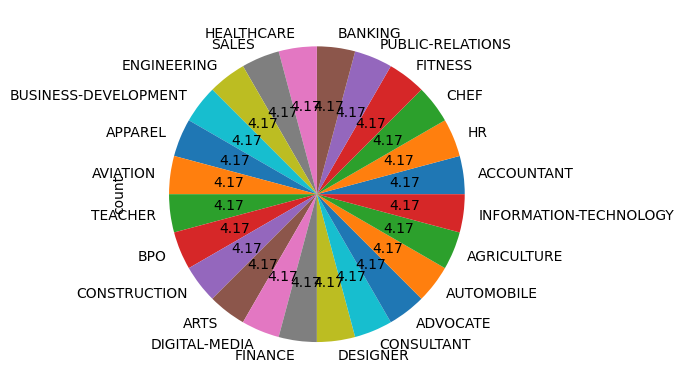

In [56]:
y= df['Category']
y.value_counts().plot.pie(autopct='%.2f')

In [57]:
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

In [58]:
def remove_stop_words(text):
  stop_words= set(stopwords.words('english'))
  words = word_tokenize(text)
  filtered_words = [word for word in words if word.lower() not in stop_words]
  filtered_text = ' '.join(filtered_words)
  return filtered_text

In [59]:
def apply_stemming(text):
  stemmer = PorterStemmer()
  words = word_tokenize(text)
  stemmed_words = [stemmer.stem(word.lower()) for word in words]
  stemmed_text = ' '.join(stemmed_words)
  return stemmed_text

In [60]:
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [61]:
def remove_numbers(text):
    pattern = r'\d+'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [62]:
def get_tokens(text):
    tokens = word_tokenize(text)
    return tokens

In [63]:
df['Resume_str'] = df['Resume_str'].apply(clean_text)
df['Resume_str'] = df['Resume_str'].apply(remove_numbers)
df['Resume_str'] = df['Resume_str'].apply(remove_stop_words)
df['Resume_str'] = df['Resume_str'].apply(apply_stemming)
df['Resume_str'] = df['Resume_str'].apply(apply_lemmatization)
df['Resume_str'] = df['Resume_str'].apply(get_tokens)

In [64]:
df.head()

,Resume_str,Category
0,"[account, profession, summari, resultsori, org...",ACCOUNTANT
1,"[hr, associ, profession, summari, enthusiast, ...",HR
2,"[logist, technician, profession, summari, driv...",AGRICULTURE
3,"[polici, servic, specialist, iii, profession, ...",AUTOMOBILE
4,"[child, perform, welfar, advoc, summari, admin...",ADVOCATE


In [65]:
df['Resume_str'] = df['Resume_str'].apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer(binary=True)
one_hot_encoded = vectorizer.fit_transform(df['Resume_str'])
feature_names = vectorizer.get_feature_names_out()
one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=feature_names)
result_df = pd.concat([df, one_hot_df], axis=1)
print(result_df)

                                             Resume_str     Category  aa  aaa  \
0     account profession summari resultsori organ bi...   ACCOUNTANT   0    0   
1     hr associ profession summari enthusiast goalor...           HR   0    0   
2     logist technician profession summari driven co...  AGRICULTURE   0    0   
3     polici servic specialist iii profession summar...   AUTOMOBILE   0    0   
4     child perform welfar advoc summari administr p...     ADVOCATE   0    0   
...                                                 ...          ...  ..  ...   
2635  execut chef profession summari dynam accomplis...         CHEF   0    0   
2636  sr network engin summari bilingu network engin...          BPO   0    1   
2637  sale associ summari reliabl friendli worker qu...        SALES   0    0   
2638  consult core qualif ganesh seetharaman senior ...   CONSULTANT   0    0   
2639  program managerbusi analyst summari highli ent...      FITNESS   0    0   

      aaacom  aaae  aaahc  

In [66]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Resume_str'])
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
result_df = pd.concat([df, tfidf_df], axis=1)
print(result_df)

                                             Resume_str     Category   aa  \
0     account profession summari resultsori organ bi...   ACCOUNTANT  0.0   
1     hr associ profession summari enthusiast goalor...           HR  0.0   
2     logist technician profession summari driven co...  AGRICULTURE  0.0   
3     polici servic specialist iii profession summar...   AUTOMOBILE  0.0   
4     child perform welfar advoc summari administr p...     ADVOCATE  0.0   
...                                                 ...          ...  ...   
2635  execut chef profession summari dynam accomplis...         CHEF  0.0   
2636  sr network engin summari bilingu network engin...          BPO  0.0   
2637  sale associ summari reliabl friendli worker qu...        SALES  0.0   
2638  consult core qualif ganesh seetharaman senior ...   CONSULTANT  0.0   
2639  program managerbusi analyst summari highli ent...      FITNESS  0.0   

           aaa  aaacom  aaae  aaahc  aac  aacc  aacn  ...  zynex  zynx  \
0

In [67]:
mean_tfidf = result_df.drop(['Resume_str', 'Category'], axis=1).mean()
tfidf_threshold = 0.003

unimportant_words = mean_tfidf[mean_tfidf < tfidf_threshold].index
result_df.drop(unimportant_words, axis=1, inplace=True)
print(result_df)

                                             Resume_str     Category  abil  \
0     account profession summari resultsori organ bi...   ACCOUNTANT   0.0   
1     hr associ profession summari enthusiast goalor...           HR   0.0   
2     logist technician profession summari driven co...  AGRICULTURE   0.0   
3     polici servic specialist iii profession summar...   AUTOMOBILE   0.0   
4     child perform welfar advoc summari administr p...     ADVOCATE   0.0   
...                                                 ...          ...   ...   
2635  execut chef profession summari dynam accomplis...         CHEF   0.0   
2636  sr network engin summari bilingu network engin...          BPO   0.0   
2637  sale associ summari reliabl friendli worker qu...        SALES   0.0   
2638  consult core qualif ganesh seetharaman senior ...   CONSULTANT   0.0   
2639  program managerbusi analyst summari highli ent...      FITNESS   0.0   

           abl  academ    access  accomplish    accord   accoun

In [68]:
result_df

,Resume_str,Category,abil,abl,academ,access,accomplish,accord,account,accur,...,word,work,worker,workflow,workshop,write,written,wrote,year,youth
0,account profession summari resultsori organ bi...,ACCOUNTANT,0.0,0.000000,0.0,0.022393,0.000000,0.000000,0.329955,0.019249,...,0.019194,0.010085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013027,0.00000
1,hr associ profession summari enthusiast goalor...,HR,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.013409,0.000000,0.000000,0.087044,0.000000,0.062813,0.000000,0.025981,0.00000
2,logist technician profession summari driven co...,AGRICULTURE,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.047998,0.000000,...,0.000000,0.067481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014528,0.00000
3,polici servic specialist iii profession summar...,AUTOMOBILE,0.0,0.095865,0.0,0.000000,0.019882,0.000000,0.000000,0.000000,...,0.000000,0.037869,0.000000,0.000000,0.000000,0.000000,0.059133,0.000000,0.000000,0.00000
4,child perform welfar advoc summari administr p...,ADVOCATE,0.0,0.031176,0.0,0.000000,0.000000,0.000000,0.070078,0.000000,...,0.000000,0.018473,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,execut chef profession summari dynam accomplis...,CHEF,0.0,0.000000,0.0,0.000000,0.027014,0.000000,0.036597,0.000000,...,0.000000,0.051452,0.000000,0.053872,0.000000,0.000000,0.000000,0.000000,0.011077,0.00000
2636,sr network engin summari bilingu network engin...,BPO,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.025075,0.000000,...,0.000000,0.011751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2637,sale associ summari reliabl friendli worker qu...,SALES,0.0,0.000000,0.0,0.000000,0.013631,0.057289,0.036933,0.033037,...,0.032943,0.008654,0.022364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2638,consult core qualif ganesh seetharaman senior ...,CONSULTANT,0.0,0.000000,0.0,0.022144,0.000000,0.011003,0.000000,0.000000,...,0.000000,0.019945,0.000000,0.000000,0.032368,0.011402,0.000000,0.000000,0.000000,0.00000


In [69]:
x = result_df.drop(['Resume_str', 'Category'], axis=1)
y = result_df['Category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

svm_classifier = SVC()
svm_classifier.fit(x_train, y_train)

y_pred = svm_classifier.predict(x_test)
print("Classification report:")
print(classification_report(y_test, y_pred))

Classification report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.94      0.88      0.91        17
              ADVOCATE       0.65      0.65      0.65        23
           AGRICULTURE       0.82      0.92      0.87        25
               APPAREL       0.75      0.81      0.78        26
                  ARTS       0.61      0.58      0.60        24
            AUTOMOBILE       0.95      0.95      0.95        20
              AVIATION       0.96      0.87      0.91        30
               BANKING       0.76      0.80      0.78        20
                   BPO       1.00      1.00      1.00        25
  BUSINESS-DEVELOPMENT       0.72      0.75      0.73        24
                  CHEF       0.88      0.78      0.82        18
          CONSTRUCTION       1.00      1.00      1.00        23
            CONSULTANT       0.68      0.65      0.67        26
              DESIGNER       0.90      0.90      0.90        29
         DIGITAL

In [72]:
def cross_val_scores(model, x, y, categories, cv):
    category_scores = {category: {'precision': [], 'recall': [], 'f1-score': [], 'support': [], 'accuracy': []} for category in categories}

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)

        for category in categories:
            category_scores[category]['precision'].append(report[category]['precision'])
            category_scores[category]['recall'].append(report[category]['recall'])
            category_scores[category]['f1-score'].append(report[category]['f1-score'])
            category_scores[category]['support'].append(report[category]['support'])
            category_accuracy = accuracy_score(y_test[y_test == category], y_pred[y_test == category])
            category_scores[category]['accuracy'].append(category_accuracy)

    mean_scores = {}
    for category in categories:
        mean_scores[category] = {
            'precision': np.mean(category_scores[category]['precision']),
            'recall': np.mean(category_scores[category]['recall']),
            'f1-score': np.mean(category_scores[category]['f1-score']),
            'support': np.mean(category_scores[category]['support']),
            'accuracy': np.mean(category_scores[category]['accuracy'])
        }

    return mean_scores


In [73]:
categories = result_df['Category'].unique()
cv_scores = cross_val_scores(svm_classifier, x, y, categories, cv=10)

for category, scores in cv_scores.items():
    print(f"Category: {category}")
    print(f"Mean Precision: {scores['precision']}")
    print(f"Mean Recall: {scores['recall']}")
    print(f"Mean F1-score: {scores['f1-score']}")
    print(f"Mean Support: {scores['support']}")
    print(f"Mean Accuracy: {scores['accuracy']}")
    print()

Category: ACCOUNTANT
Mean Precision: 0.8508408258408258
Mean Recall: 0.9
Mean F1-score: 0.8698363497676999
Mean Support: 11.0
Mean Accuracy: 0.9

Category: HR
Mean Precision: 0.8117549117549118
Mean Recall: 0.7363636363636364
Mean F1-score: 0.7663317384370016
Mean Support: 11.0
Mean Accuracy: 0.9818181818181818

Category: AGRICULTURE
Mean Precision: 0.7935214785214785
Mean Recall: 0.8181818181818181
Mean F1-score: 0.8002141717931192
Mean Support: 11.0
Mean Accuracy: 0.8181818181818181

Category: AUTOMOBILE
Mean Precision: 0.7741189366189365
Mean Recall: 0.7363636363636364
Mean F1-score: 0.7489433233941244
Mean Support: 11.0
Mean Accuracy: 0.8454545454545453

Category: ADVOCATE
Mean Precision: 0.722332251082251
Mean Recall: 0.6727272727272728
Mean F1-score: 0.6808282557643173
Mean Support: 11.0
Mean Accuracy: 0.7363636363636364

Category: CONSULTANT
Mean Precision: 0.9675324675324675
Mean Recall: 0.8454545454545453
Mean F1-score: 0.8984096605149237
Mean Support: 11.0
Mean Accuracy: 0.70

In [74]:
overall_accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy:", overall_accuracy)

Overall accuracy: 0.8257575757575758


In [75]:
def predict_all_samples(x, y, model):
    y_pred = model.predict(x)
    return list(zip(range(len(x)), y, y_pred))

In [76]:
x_combined = pd.concat([x_train, x_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)
predicted_samples = predict_all_samples(x_combined, y_combined, svm_classifier)
print("Predicted all samples:")
for sample in predicted_samples:
    print(sample)

Predicted all samples:
(0, 'FINANCE', 'FINANCE')
(1, 'AGRICULTURE', 'AGRICULTURE')
(2, 'INFORMATION-TECHNOLOGY', 'INFORMATION-TECHNOLOGY')
(3, 'SALES', 'SALES')
(4, 'PUBLIC-RELATIONS', 'PUBLIC-RELATIONS')
(5, 'ADVOCATE', 'ADVOCATE')
(6, 'HEALTHCARE', 'HEALTHCARE')
(7, 'SALES', 'SALES')
(8, 'BUSINESS-DEVELOPMENT', 'BUSINESS-DEVELOPMENT')
(9, 'AVIATION', 'AVIATION')
(10, 'SALES', 'SALES')
(11, 'CONSTRUCTION', 'CONSTRUCTION')
(12, 'BUSINESS-DEVELOPMENT', 'BUSINESS-DEVELOPMENT')
(13, 'ACCOUNTANT', 'ACCOUNTANT')
(14, 'FITNESS', 'FITNESS')
(15, 'ACCOUNTANT', 'ACCOUNTANT')
(16, 'DESIGNER', 'DESIGNER')
(17, 'ACCOUNTANT', 'ACCOUNTANT')
(18, 'CHEF', 'CHEF')
(19, 'HR', 'HR')
(20, 'BANKING', 'BANKING')
(21, 'AVIATION', 'AVIATION')
(22, 'HEALTHCARE', 'HEALTHCARE')
(23, 'BUSINESS-DEVELOPMENT', 'BUSINESS-DEVELOPMENT')
(24, 'AVIATION', 'AVIATION')
(25, 'BANKING', 'BANKING')
(26, 'BPO', 'BPO')
(27, 'FINANCE', 'FINANCE')
(28, 'AUTOMOBILE', 'AUTOMOBILE')
(29, 'ARTS', 'ARTS')
(30, 'CHEF', 'CHEF')
(31, 'IN

In [77]:
def show_wrong_predictions(predicted_samples):
    wrong_predictions = []
    for sample in predicted_samples:
        index, true_label, predicted_label = sample
        if true_label != predicted_label:
            wrong_predictions.append(sample)
    return wrong_predictions

In [78]:
wrongly_predicted_samples = show_wrong_predictions(predicted_samples)
if wrongly_predicted_samples:
    print("Wrongly predicted samples:")
    for sample in wrongly_predicted_samples:
        print("Index:", sample[0])
        print("True label:", sample[1])
        print("Predicted label:", sample[2])
        print()
else:
    print("No wrongly predicted samples.")

Wrongly predicted samples:
Index: 54
True label: FINANCE
Predicted label: ACCOUNTANT

Index: 86
True label: HEALTHCARE
Predicted label: BANKING

Index: 114
True label: CONSULTANT
Predicted label: INFORMATION-TECHNOLOGY

Index: 168
True label: AVIATION
Predicted label: ARTS

Index: 185
True label: AVIATION
Predicted label: PUBLIC-RELATIONS

Index: 206
True label: CONSULTANT
Predicted label: ENGINEERING

Index: 263
True label: APPAREL
Predicted label: PUBLIC-RELATIONS

Index: 281
True label: APPAREL
Predicted label: ARTS

Index: 293
True label: BUSINESS-DEVELOPMENT
Predicted label: HEALTHCARE

Index: 302
True label: APPAREL
Predicted label: ADVOCATE

Index: 305
True label: AVIATION
Predicted label: INFORMATION-TECHNOLOGY

Index: 306
True label: FITNESS
Predicted label: SALES

Index: 409
True label: CONSULTANT
Predicted label: AGRICULTURE

Index: 432
True label: BUSINESS-DEVELOPMENT
Predicted label: AGRICULTURE

Index: 434
True label: AVIATION
Predicted label: INFORMATION-TECHNOLOGY

Inde